In [1]:
import numpy as np
from typing import Union, Iterable, Sized, Tuple
import torch
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
import math
import os
import random
import logging
from torch.utils.data import TensorDataset, DataLoader
from absl import app, flags
from tqdm import tqdm
from torchinfo import summary

import sys
sys.path.append(r'C:\Users\yuval\dev\MSC\multi-classification-NAM')

from model import ExULayer, ReLULayer, MonotonicLayer, LipschitzMonotonicLayer, NeuralAdditiveModel, HierarchNeuralAdditiveModel

In [3]:
#!pip install wandb --upgrade
#!pip install monotonicnetworks

In [4]:
import monotonicnetworks as lmn

In [5]:
# import wandb
# wandb.login()

# run = wandb.init(
#     project="nam-original",
#     notes="My first experiment",
#     tags=["baseline"],
# )

In [2]:
# Ensure deterministic behavior
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataset

In [3]:
def get_synthetic_data_phase1(num_exp=10, in_features=10):
#     # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
#     X_uniform = Uniform(0, 3).sample((num_exp, in_features-5))
    
#     # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
#     X_normal = torch.normal(1.5, 0.5, (num_exp, 5))
    
#     # Combine the uniform and normal features
#     X = torch.cat([X_uniform, X_normal], dim=1)
    X = Uniform(0, 3).sample((num_exp, in_features))
    print(X.shape)
    
    # creating y_1
    # y_1 = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = X[:, 0] + 2*(X[:, 1]**2) + (1/3)*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (2/3) * torch.log(100 * X[:, 5].abs()) + torch.cos(5 * X[:, 6])
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # creating y_3
    y_3 = (3/4) * torch.exp(-4 * X[:, 7].abs()) + 0.5*(torch.sin(5 * X[:, 8])+1)
    y_3 = y_3.reshape(-1, 1)
    
    # creating y_4
    y_4 = torch.exp(0.5 * X[:, 5]) + 0.5*(X[:, 2]**2)
    y_4 = y_4.reshape(-1, 1)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2, y_3, y_4], dim=1)
    print(y.shape)
    
    return X, y


def get_synthetic_data_phase2(X_input):
    
    # creating y_1
    y_1 = - X_input[:, 0] - 2*X_input[:, 2]
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = 3*X_input[:, 1]
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2], dim=1)
    print(y.shape)
    
    return y


def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [4]:
X, y_phase1 = get_synthetic_data_phase1(num_exp=3, in_features=10)
y_phase2 = get_synthetic_data_phase2(y_phase1)

torch.Size([3, 10])
torch.Size([3, 4])
torch.Size([3, 2])


In [5]:
y_phase1

tensor([[3.4091, 3.5546, 0.7895, 4.4757],
        [5.1517, 2.4685, 0.8087, 2.2391],
        [5.1193, 2.4271, 0.9658, 2.4924]])

In [6]:
y_phase2

tensor([[-4.9880, 10.6638],
        [-6.7691,  7.4054],
        [-7.0509,  7.2812]])

# MODEL

# Loss

In [7]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    loss = mse_loss+feat_loss
    return loss

def l1_penalty(params, l1_lambda):
    l1_norm =  torch.stack([torch.linalg.norm(p, 1) for p in params], dim=0).sum()
    return l1_lambda*l1_norm

def l2_penalty(params, l1_lambda):
    l2_norm =  torch.stack([torch.linalg.norm(p, 2) for p in params], dim=0).sum()
    return l1_lambda*l2_norm

# Model training

In [8]:
def train(model, loader, criterion, optimizer, config):
    
    # Run training and track with wandb
#    total_batches = len(loader) * config['epochs']
#    batch_ct = 0
    loss_history = []

    for epoch in tqdm(range(config['epochs'])):
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):
            loss = train_batch(X, y, model, optimizer, criterion)
#            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):    
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, fnns_out = model(X)
    loss = criterion(logits, y, fnns_out, feature_penalty=0.0002)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    if 0:
        print('predict outputs shape:',logits.shape)
        print('true outputs shape:',y.shape)
        print('fnns_out shape:',fnns_out.shape)

    return loss

# Define the Experiment

In [13]:
# define experiment
def define_experiment(ActivateLayers_pase1='ReLU', ActivateLayers_pase2=None):
    config = dict(
                epochs=2000,#2000, #100
                batch_size=1024, #128
                learning_rate=0.0035,
                weight_decay=0.0001,
                num_exp = 50000,
                in_features = 10,    
                seed=42,
                dataset="gen_uniform_distribution_data",
                model_architecture="multi_output_NAM"
                )
    
    if ActivateLayers_pase2 is not None:
        hirarchical_net = [ActivateLayers_pase1, ActivateLayers_pase2]
    else:
        hirarchical_net = [ActivateLayers_pase1]
    config['hirarchical_net'] = hirarchical_net

    for phase in range(len(hirarchical_net)):
        if hirarchical_net[phase] == 'ReLU':
            config[f'first_ActivateLayer_phase{phase+1}'] = ReLULayer
            config[f'first_hidden_dim_phase{phase+1}'] = 64           
            config[f'shallow_phase{phase+1}'] = False
            config[f'hidden_ActivateLayer_phase{phase+1}'] = ReLULayer
            config[f'hidden_dim_phase{phase+1}'] = [64, 32]
            config[f'hidden_dropout_phase{phase+1}'] = 0.2
            config[f'feature_dropout_phase{phase+1}'] = 0.3
            config[f'featureNN_arch_phase{phase+1}'] = 'multi_output' #'single_to_multi_output'
            config[f'weight_norms_kind_phase{phase+1}'] = None
            config[f'group_size_phase{phase+1}'] = None
            config[f'monotonic_constraint_phase{phase+1}'] = None
            if phase==0:
                config['latent_dim'] = 4
            else:
                config['output_dim'] = 2

        elif hirarchical_net[phase] == 'ExU':
            config[f'first_ActivateLayer_phase{phase+1}'] = ExULayer
            config[f'first_hidden_dim_phase{phase+1}'] = 1024           
            config[f'shallow_phase{phase+1}'] = True
            config[f'hidden_dropout_phase{phase+1}'] = 0.4
            config[f'feature_dropout_phase{phase+1}'] = 0.2
            config[f'featureNN_arch_phase{phase+1}'] = 'multi_output'
            config[f'weight_norms_kind_phase{phase+1}'] = None
            config[f'group_size_phase{phase+1}'] = None
            config[f'monotonic_constraint_phase{phase+1}'] = None
            if phase==0:
                config['latent_dim'] = 4
            else:
                config['output_dim'] = 2

        elif hirarchical_net[phase] == 'LipschitzMonotonic':
            config[f'first_ActivateLayer_phase{phase+1}'] = LipschitzMonotonicLayer
            config[f'first_hidden_dim_phase{phase+1}'] = 128           
            config[f'shallow_phase{phase+1}'] = False
            config[f'hidden_ActivateLayer_phase{phase+1}'] = LipschitzMonotonicLayer
            config[f'hidden_dim_phase{phase+1}'] = [128, 64]
            config[f'hidden_dropout_phase{phase+1}'] = 0
            config[f'feature_dropout_phase{phase+1}'] = 0
            config[f'featureNN_arch_phase{phase+1}'] = 'monotonic_hidden_layer'
            config[f'weight_norms_kind_phase{phase+1}'] = "one-inf"
            config[f'group_size_phase{phase+1}'] = 2
            config[f'monotonic_constraint_phase{phase+1}'] = None
            if phase==0:
                config['latent_dim'] = 4
            else:
                config['output_dim'] = 2
                
    return config

In [14]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])
    Y = get_synthetic_data_phase2(y)

    # Make the model
    if len(config['hirarchical_net']) == 2:
        print("Training Hierarchical NAM...")
        print(f"Phase1 activation layers: {config['hirarchical_net'][0]}\nPhase2 activation layers: {config['hirarchical_net'][1]}")
        
        train_loader = make_loader(X, Y, batch_size=config['batch_size'])
        
        model = HierarchNeuralAdditiveModel(
                            num_inputs= config['in_features'],
                      #phase1 - latent_features:
                            num_units_phase1= config['first_hidden_dim_phase1'],
                            hidden_units_phase1= config['hidden_dim_phase1'],
                            hidden_dropout_phase1 = config['hidden_dropout_phase1'],
                            feature_dropout_phase1 = config['feature_dropout_phase1'],
                            shallow_phase1 = config['shallow_phase1'],     
                            first_layer_phase1 = config['first_ActivateLayer_phase1'],
                            hidden_layer_phase1 = config['hidden_ActivateLayer_phase1'],
                            latent_var_dim = config['latent_dim'],
                            featureNN_architecture_phase1 = config['featureNN_arch_phase1'],
                            weight_norms_kind_phase1 = config['weight_norms_kind_phase1'],
                            group_size_phase1 = config['group_size_phase1'],
                            monotonic_constraint_phase1 = config['monotonic_constraint_phase1'],
                      #phase2 - final outputs:
                            num_units_phase2 = config['first_hidden_dim_phase2'],
                            hidden_units_phase2 = config['hidden_dim_phase2'],
                            hidden_dropout_phase2 = config['hidden_dropout_phase2'],
                            feature_dropout_phase2 = config['feature_dropout_phase2'],
                            shallow_phase2 = config['shallow_phase2'],
                            first_layer_phase2 = config['first_ActivateLayer_phase2'],
                            hidden_layer_phase2 = config['hidden_ActivateLayer_phase2'],        
                            output_dim = config['output_dim'],
                            featureNN_architecture_phase2 = config['featureNN_arch_phase2'],
                            weight_norms_kind_phase2 = config['weight_norms_kind_phase2'],
                            group_size_phase2 = config['group_size_phase2'],
                            monotonic_constraint_phase2 = config['monotonic_constraint_phase2'],
                            ).to(device)
    else:
        print('Training NAM...')
        print(f"Activation layers: {config['hirarchical_net'][0]}")
        
        train_loader = make_loader(X, y, batch_size=config['batch_size'])
        
        model = NeuralAdditiveModel(num_inputs= config['in_features'],
                     num_units= config['first_hidden_dim_phase1'],
                     hidden_units= config['hidden_dim_phase1'],
                     hidden_dropout = config['hidden_dropout_phase1'],
                     feature_dropout = config['feature_dropout_phase1'],
                     shallow = config['shallow_phase1'],     
                     first_layer = config['first_ActivateLayer_phase1'],
                     hidden_layer = config['hidden_ActivateLayer_phase1'],
                     num_classes = config['latent_dim'],
                     architecture_type = config['featureNN_arch_phase1'],
                     weight_norms_kind = config['weight_norms_kind_phase1'],
                     group_size = config['group_size_phase1'], 
                     monotonic_constraint = config['monotonic_constraint_phase1'],        
                     ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer

In [15]:
def visualize_gam(x_values, input_dim, output_dim, config, vis_lat_features = False):
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if len(config['hirarchical_net']) == 2:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                feature_output_max[f'output_{j}'].append(max(feature_output)) 
                feature_output_min[f'output_{j}'].append(min(feature_output))

    for i in range(input_dim):
        with torch.no_grad(): 
            for j in range(output_dim):
                ax1 = axes[i, j]
                if len(config['hirarchical_net']) == 2:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Feature {i+1}')
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

    plt.tight_layout()
    plt.show()
    return

# Run

##  NAM - ReLU

<ipython-input-66-d27d03ff7498>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))


torch.Size([5000, 10])
torch.Size([5000, 4])
torch.Size([5000, 2])
Training NAM...
Activation layers: ReLU
Number of parameters: 64654


  0%|                                                                                 | 1/1000 [00:00<10:01,  1.66it/s]

Epoch 0 | Total Loss: 9.10893


 10%|███████▉                                                                       | 101/1000 [01:03<09:12,  1.63it/s]

Epoch 100 | Total Loss: 1.41567


 20%|███████████████▉                                                               | 201/1000 [02:00<07:31,  1.77it/s]

Epoch 200 | Total Loss: 1.25268


 30%|███████████████████████▊                                                       | 301/1000 [02:54<06:04,  1.92it/s]

Epoch 300 | Total Loss: 1.14894


 40%|███████████████████████████████▋                                               | 401/1000 [03:49<06:28,  1.54it/s]

Epoch 400 | Total Loss: 1.08012


 50%|███████████████████████████████████████▌                                       | 501/1000 [04:51<05:09,  1.61it/s]

Epoch 500 | Total Loss: 1.00251


 60%|███████████████████████████████████████████████▍                               | 601/1000 [05:56<04:23,  1.51it/s]

Epoch 600 | Total Loss: 0.99537


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [07:06<03:36,  1.38it/s]

Epoch 700 | Total Loss: 0.96987


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [08:21<02:35,  1.28it/s]

Epoch 800 | Total Loss: 0.94967


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [09:40<01:18,  1.26it/s]

Epoch 900 | Total Loss: 0.96446


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:03<00:00,  1.51it/s]


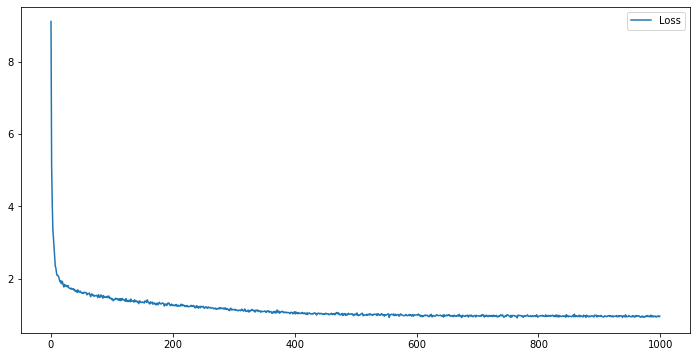

In [79]:
ActivateLayers_pase1 ='ReLU' # ReLU, ExU, LipschitzMonotonic, ExU_ReLU
ActivateLayers_pase2 ='LipschitzMonotonic' # ReLU, ExU, LipschitzMonotonic, ExU_ReLU

config = define_experiment(ActivateLayers_pase1='ReLU')

# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

if 0:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel()} parameters')
if 0:
    print(summary(model,input_size=(1, 10)))

# train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()


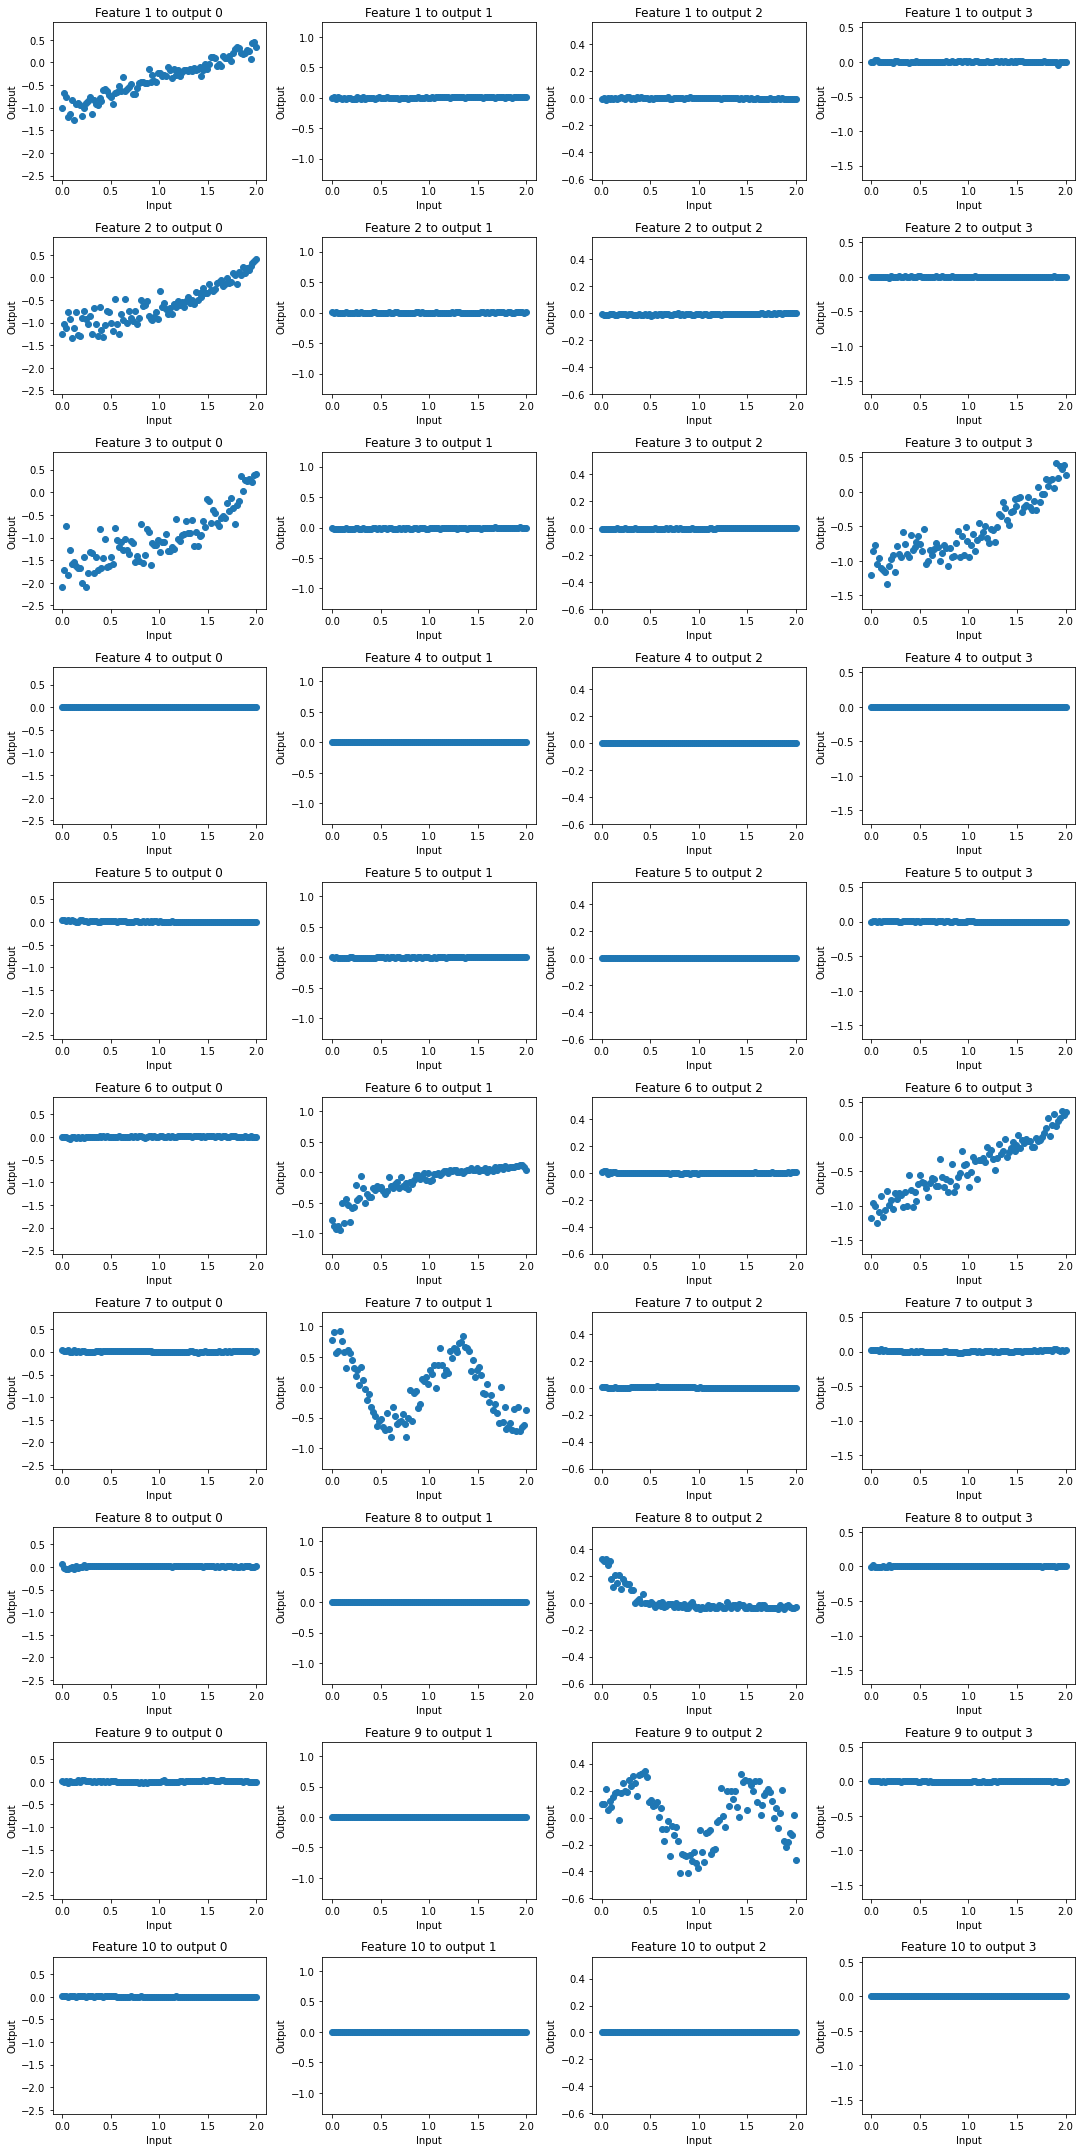

In [80]:
# Generate input values for plotting
x_values = torch.linspace(0, 2, 100).reshape(-1, 1)  # 100 points between -1 and 1

input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, config, vis_lat_features)

# NAM - LipschitzMonotonic

<ipython-input-7-d27d03ff7498>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))


torch.Size([5000, 10])
torch.Size([5000, 4])
torch.Size([5000, 2])
Training NAM...
Activation layers: LipschitzMonotonic
Number of parameters: 505654


  0%|                                                                                 | 1/1000 [00:01<26:10,  1.57s/it]

Epoch 0 | Total Loss: 13.25074


 10%|███████▉                                                                       | 101/1000 [02:32<23:06,  1.54s/it]

Epoch 100 | Total Loss: 2.14171


 20%|███████████████▉                                                               | 201/1000 [05:12<22:11,  1.67s/it]

Epoch 200 | Total Loss: 1.75340


 30%|███████████████████████▊                                                       | 301/1000 [08:15<21:57,  1.88s/it]

Epoch 300 | Total Loss: 1.54298


 40%|███████████████████████████████▋                                               | 401/1000 [11:23<20:44,  2.08s/it]

Epoch 400 | Total Loss: 1.44933


 50%|███████████████████████████████████████▌                                       | 501/1000 [14:51<16:21,  1.97s/it]

Epoch 500 | Total Loss: 1.40717


 60%|███████████████████████████████████████████████▍                               | 601/1000 [18:08<13:17,  2.00s/it]

Epoch 600 | Total Loss: 1.38612


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [21:34<10:34,  2.12s/it]

Epoch 700 | Total Loss: 1.33266


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [25:20<07:53,  2.38s/it]

Epoch 800 | Total Loss: 1.33801


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [29:12<04:00,  2.43s/it]

Epoch 900 | Total Loss: 1.31621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [33:12<00:00,  1.99s/it]


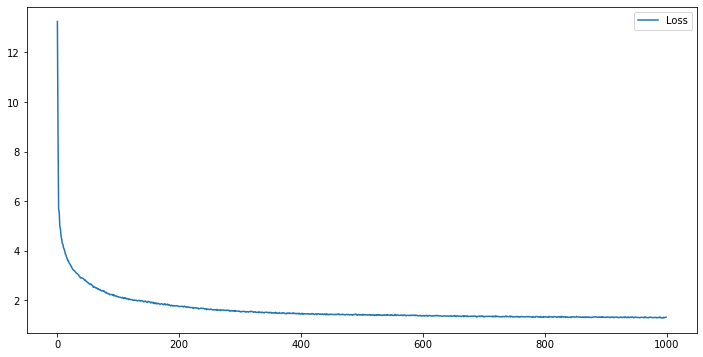

In [22]:
ActivateLayers_pase1 ='ReLU' # ReLU, ExU, LipschitzMonotonic, ExU_ReLU
ActivateLayers_pase2 ='LipschitzMonotonic' # ReLU, ExU, LipschitzMonotonic, ExU_ReLU

config = define_experiment(ActivateLayers_pase1='LipschitzMonotonic')

# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

if 0:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel()} parameters')
if 0:
    print(summary(model,input_size=(1, 10)))

# train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

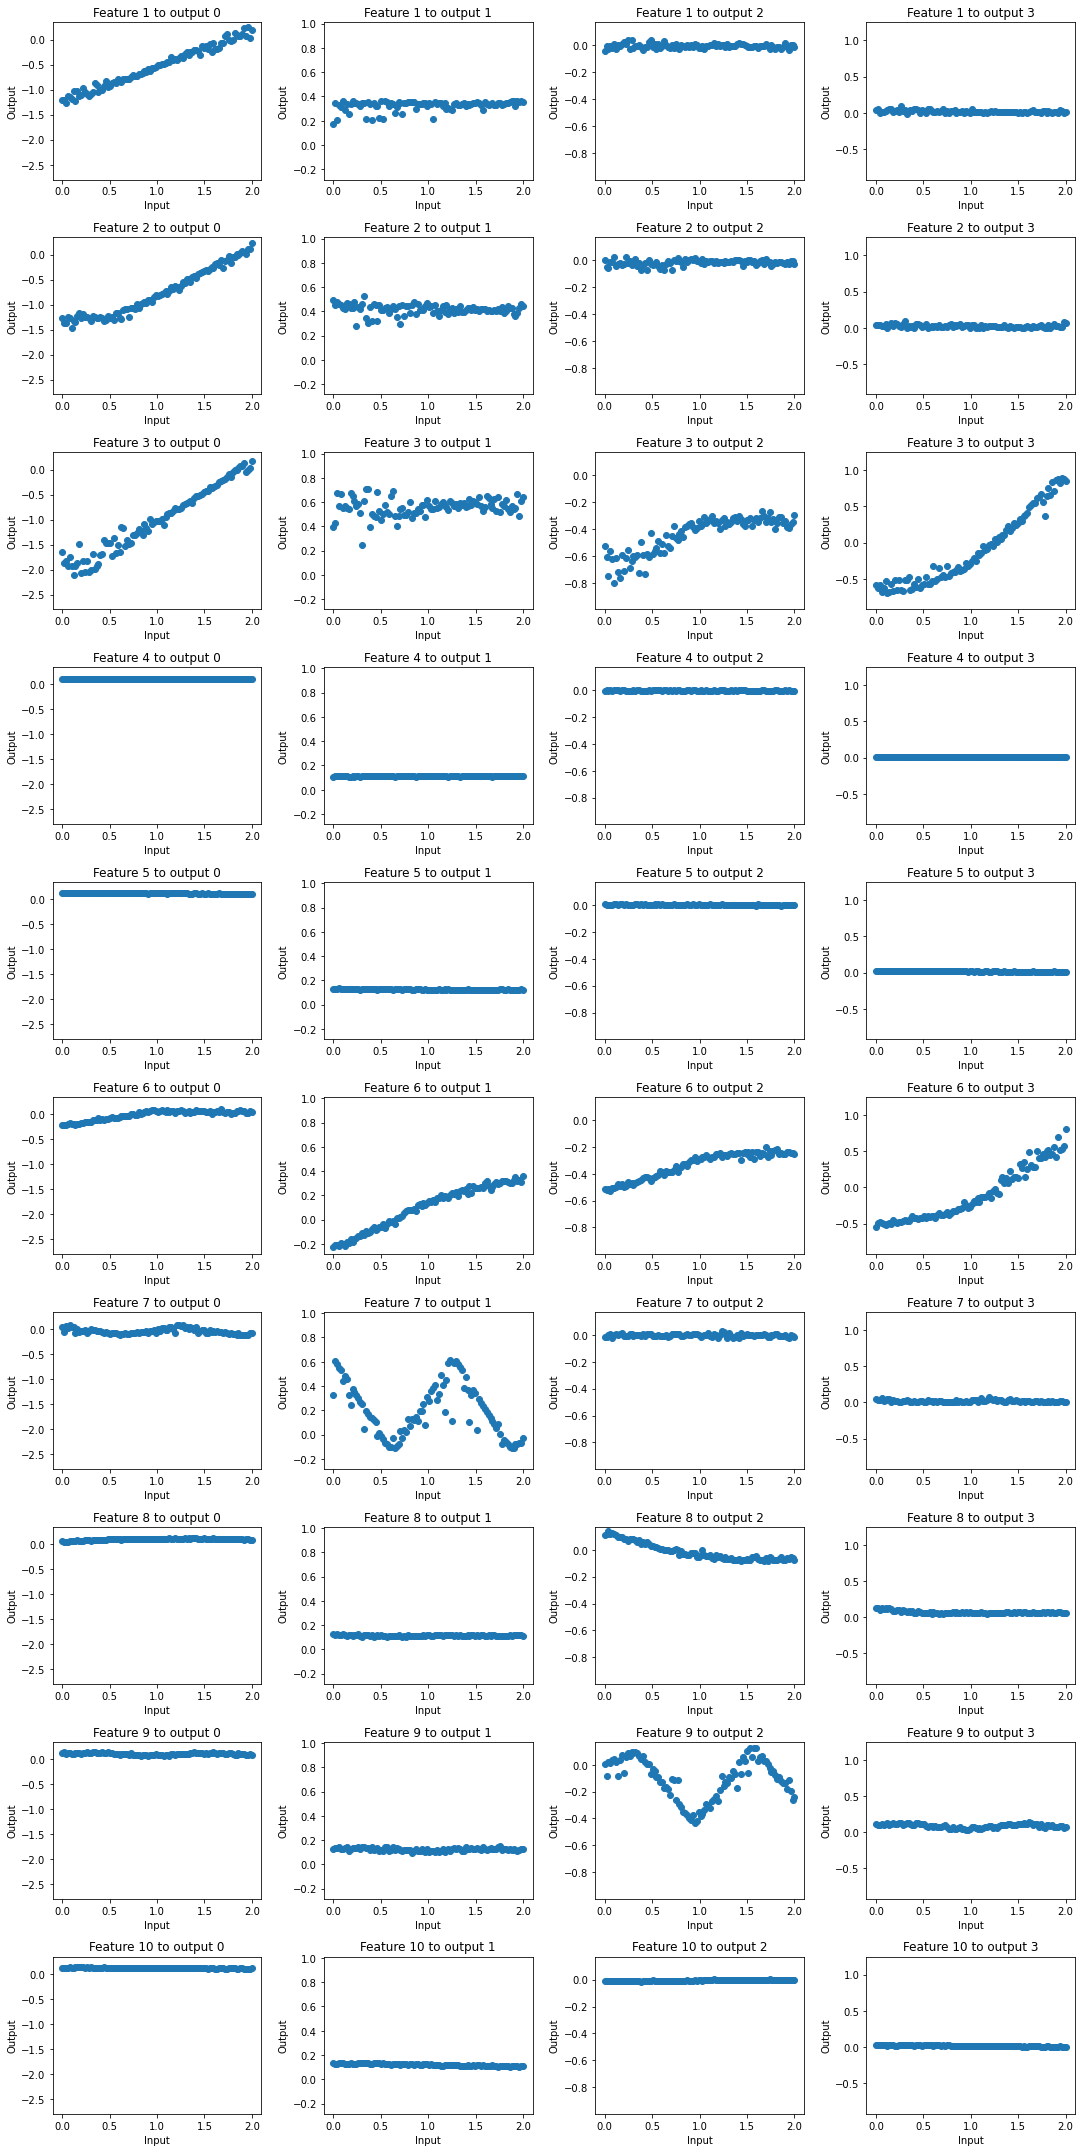

In [23]:
# Generate input values for plotting
x_values = torch.linspace(0, 2, 100).reshape(-1, 1)  # 100 points between -1 and 1

input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, config)

# HIRARCHICAL NAM - ReLU + LipschitzMonotonic

In [ ]:
ActivateLayers_pase1 ='ReLU' # ReLU, ExU, LipschitzMonotonic, ExU_ReLU
ActivateLayers_pase2 ='LipschitzMonotonic' # ReLU, ExU, LipschitzMonotonic, ExU_ReLU

config = define_experiment(ActivateLayers_pase1='ReLU', ActivateLayers_pase2='LipschitzMonotonic')

# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)

if 0:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel()} parameters')
if 0:
    print(summary(model,input_size=(1, 10)))

# train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

# Generate input values for plotting
x_values = torch.linspace(0, 4, 500).reshape(-1, 1)  # 100 points between -1 and 1

input_dim = config['latent_dim']
output_dim = config['output_dim']
visualize_gam(x_values, input_dim, output_dim, config)

<ipython-input-3-c29bd53c912e>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))


torch.Size([50000, 10])
torch.Size([50000, 4])
torch.Size([50000, 2])
Training Hierarchical NAM...
Phase1 activation layers: ReLU
Phase2 activation layers: LipschitzMonotonic


  0%|                                                                           | 1/2000 [00:09<5:08:16,  9.25s/it]

Epoch 0 | Total Loss: 44.90427


  5%|███▋                                                                     | 101/2000 [17:54<6:36:52, 12.54s/it]

Epoch 100 | Total Loss: 6.35617


 10%|███████▎                                                                 | 201/2000 [44:12<8:37:46, 17.27s/it]

Epoch 200 | Total Loss: 5.93013


 15%|██████████▌                                                           | 301/2000 [1:19:02<11:38:52, 24.68s/it]

Epoch 300 | Total Loss: 5.81159


 20%|██████████████                                                        | 401/2000 [2:01:00<12:13:25, 27.52s/it]

Epoch 400 | Total Loss: 5.80116


 25%|█████████████████▌                                                    | 501/2000 [2:51:44<14:05:53, 33.86s/it]

Epoch 500 | Total Loss: 5.75749


 30%|█████████████████████                                                 | 601/2000 [3:54:44<15:47:31, 40.64s/it]

Epoch 600 | Total Loss: 5.71850


 35%|████████████████████████▌                                             | 701/2000 [5:04:54<15:17:42, 42.39s/it]

Epoch 700 | Total Loss: 5.66608


 40%|████████████████████████████                                          | 801/2000 [6:19:49<15:34:26, 46.76s/it]

Epoch 800 | Total Loss: 5.71846


 45%|███████████████████████████████▌                                      | 901/2000 [7:42:30<15:57:54, 52.30s/it]

Epoch 900 | Total Loss: 5.72152


 46%|████████████████████████████████▏                                     | 921/2000 [8:01:50<22:54:12, 76.42s/it]

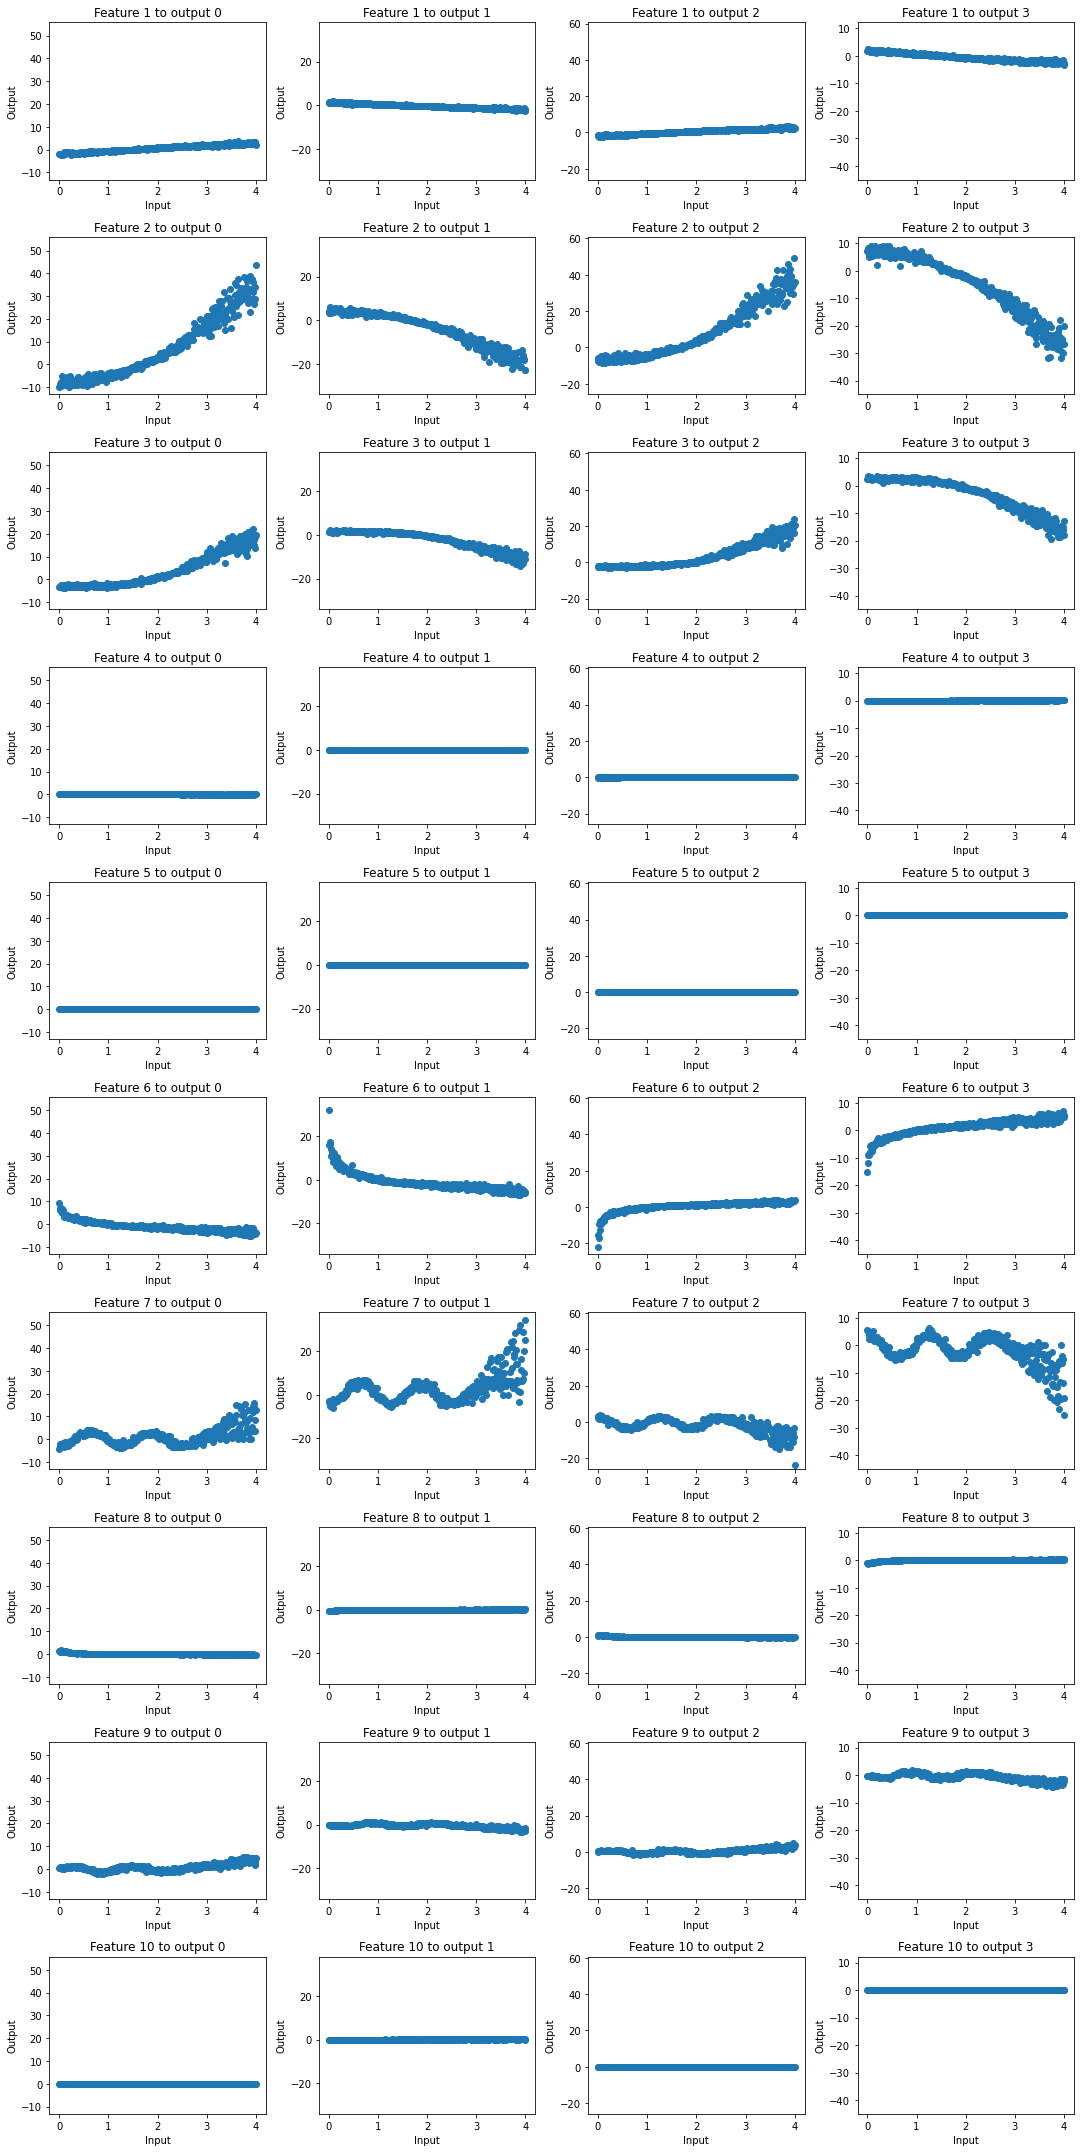

In [42]:
# Generate input values for plotting
x_values = torch.linspace(0, 4, 400).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, config, vis_lat_features)

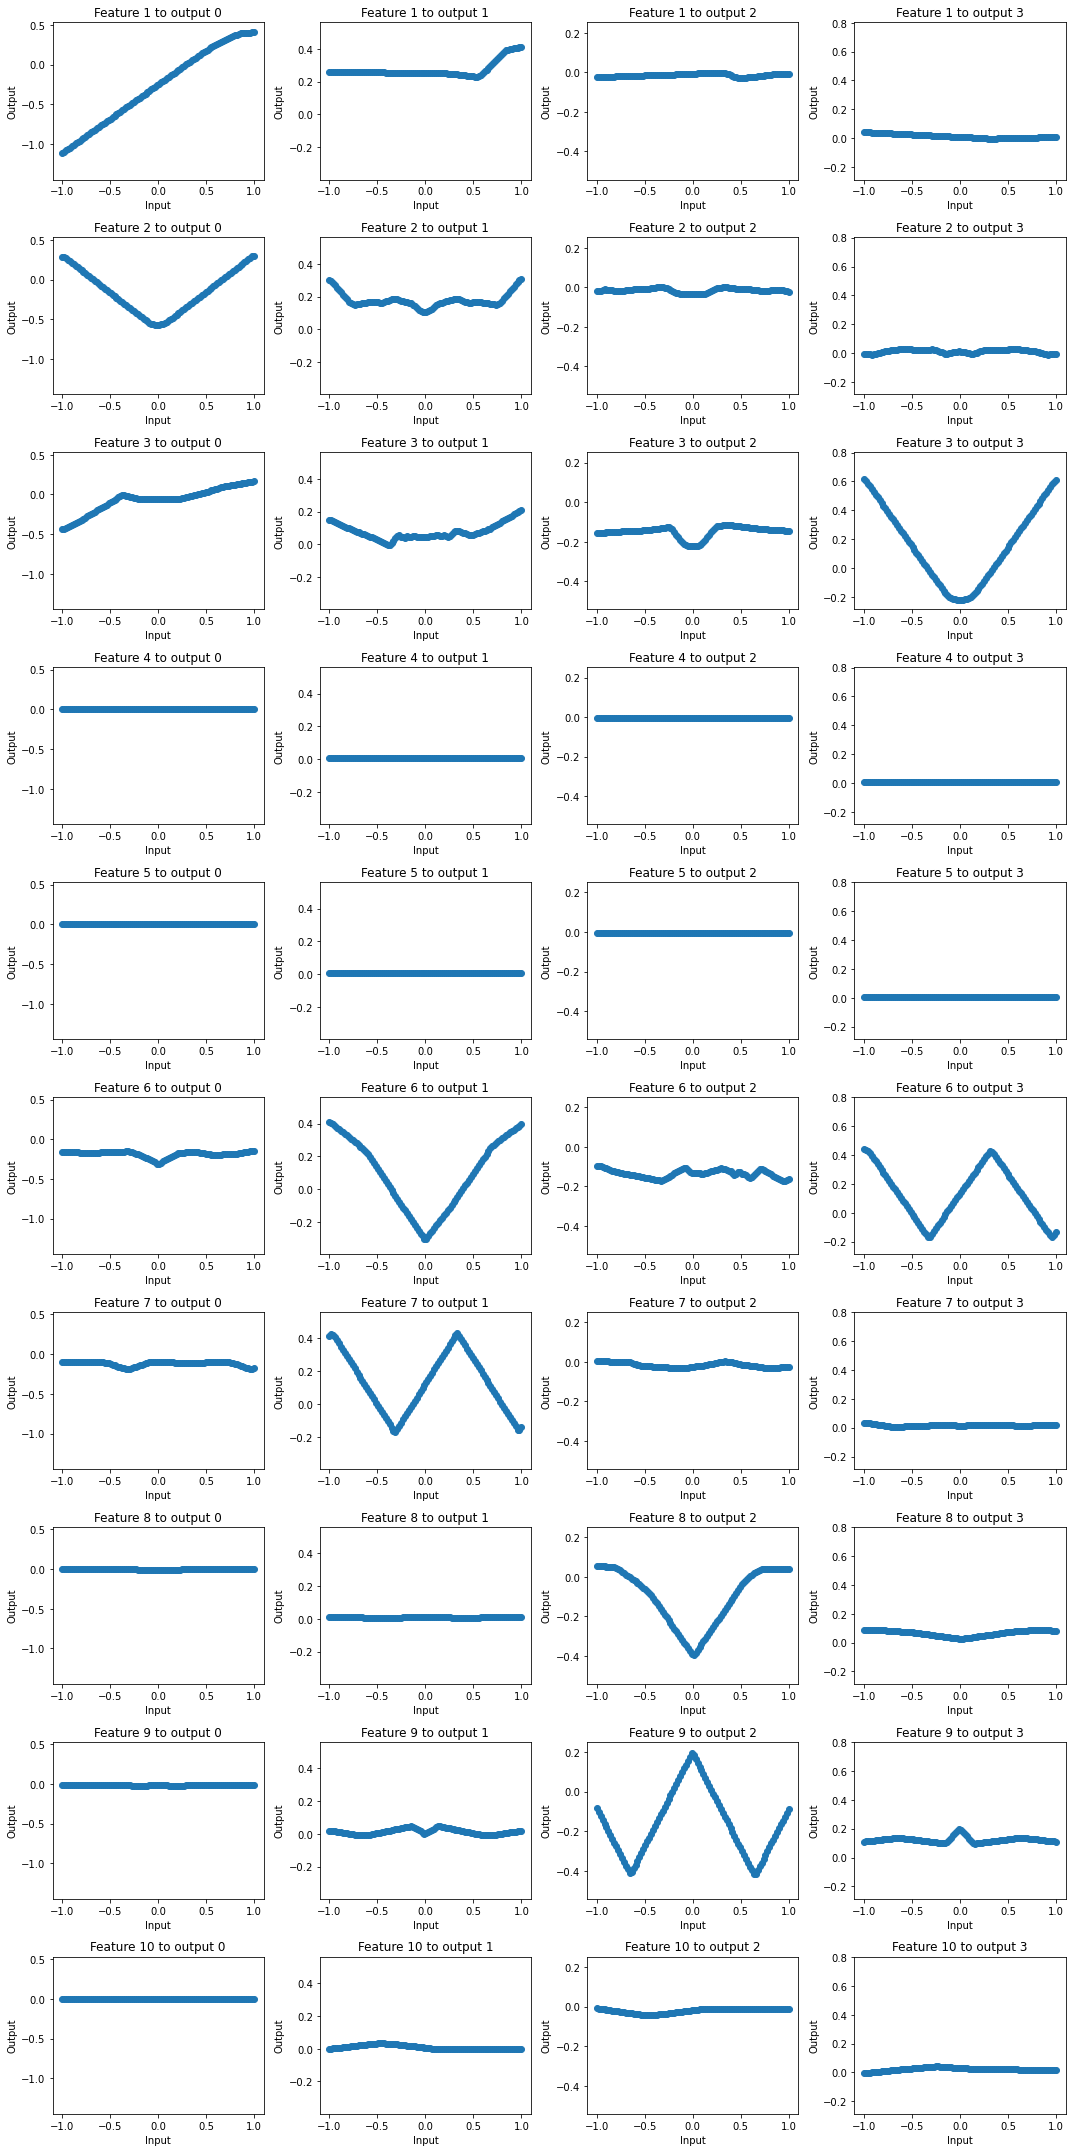

In [26]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, config, vis_lat_features)

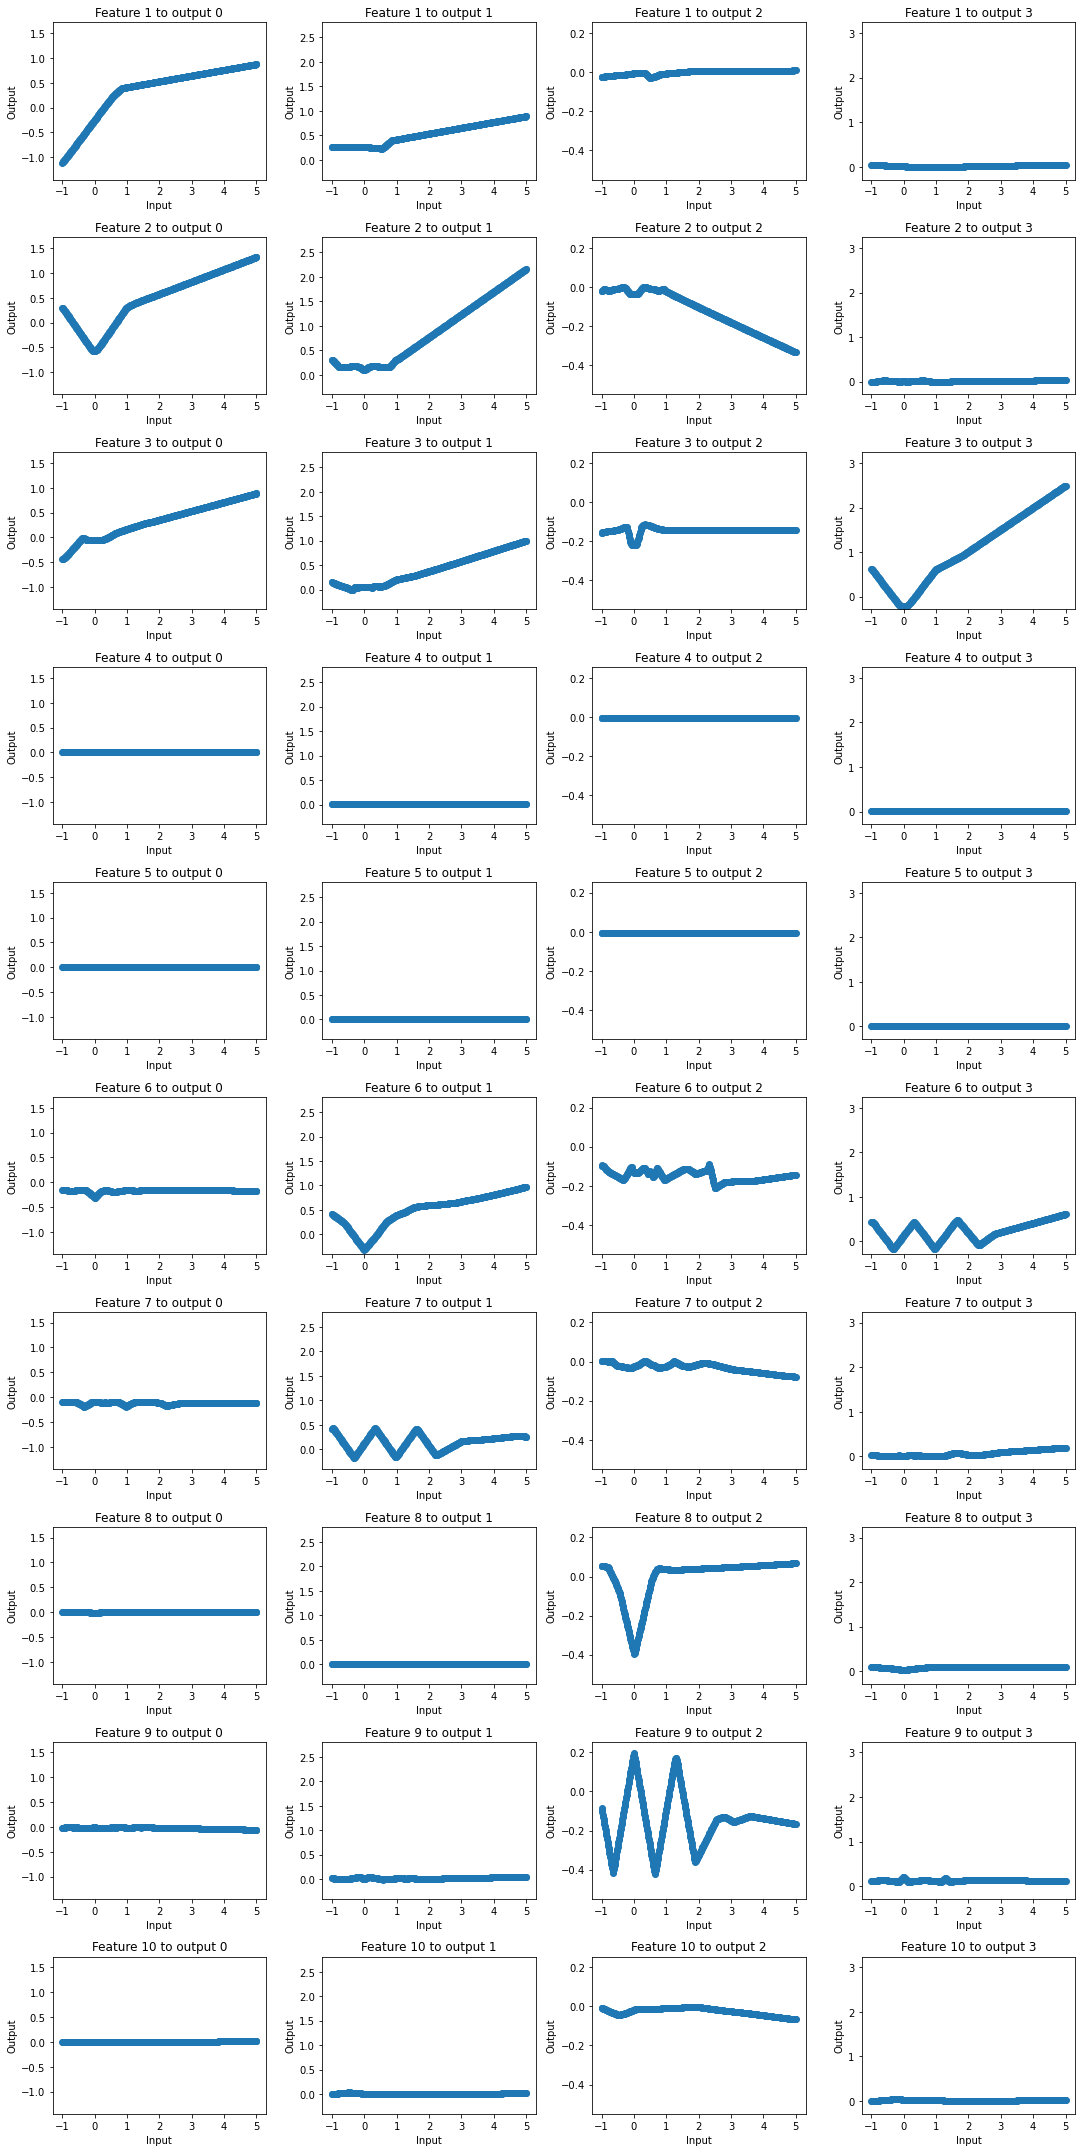

In [25]:
# Generate input values for plotting
x_values = torch.linspace(-1, 5, 500).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, config, vis_lat_features)

AttributeError: 'NeuralAdditiveModel' object has no attribute 'NAM_features'

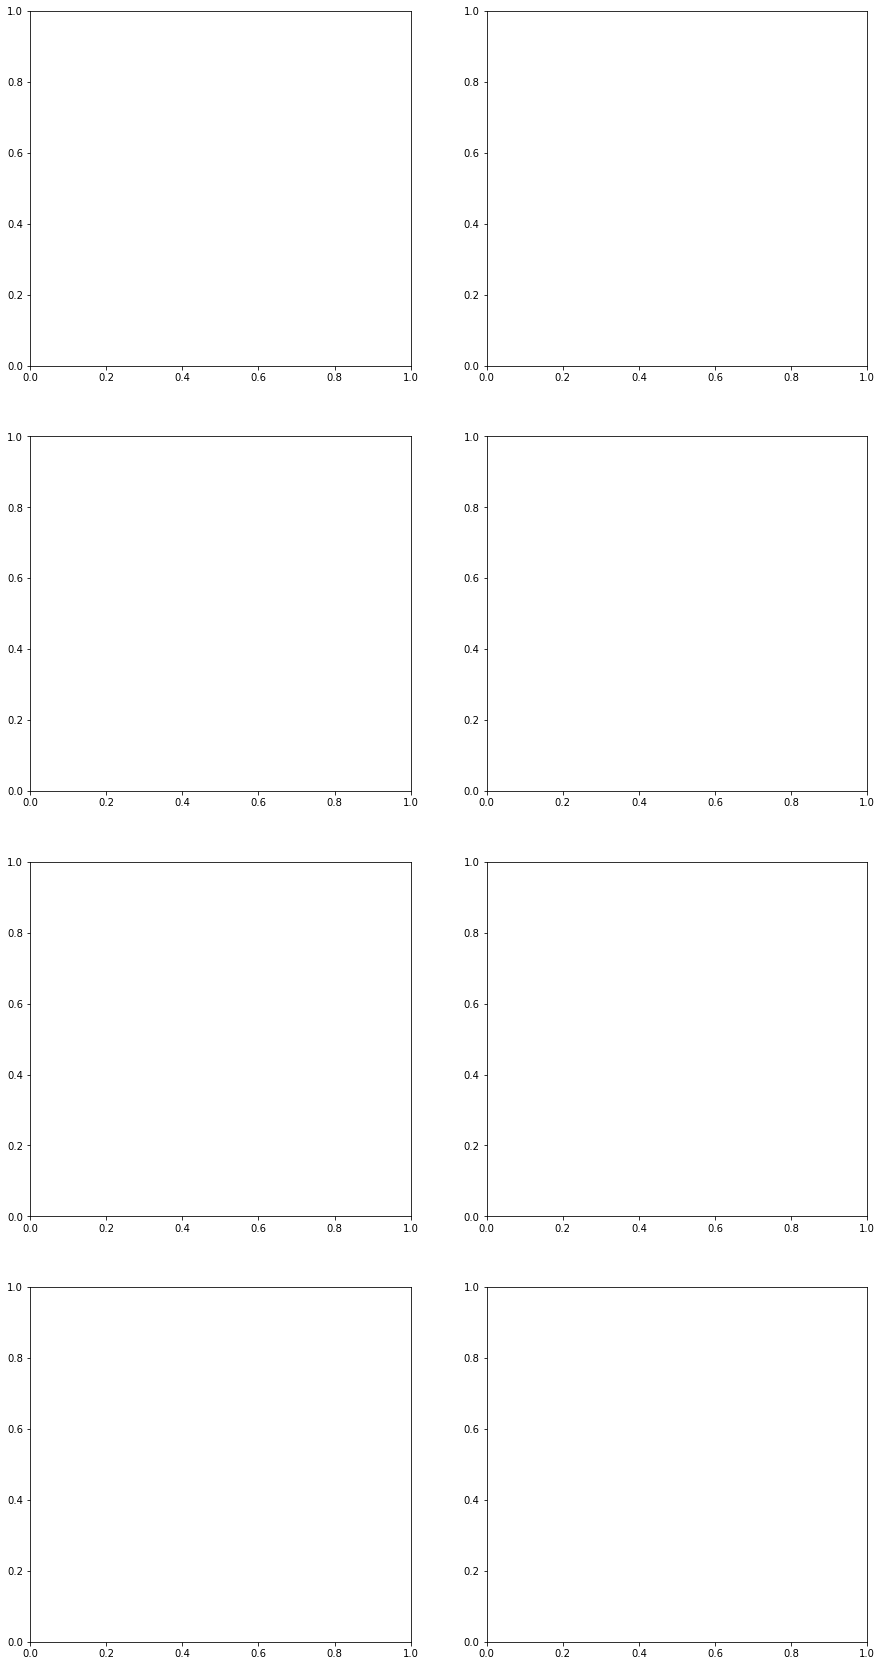

In [19]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['latent_dim']
output_dim = config['output_dim']
visualize_gam(x_values, input_dim, output_dim, config, vis_lat_features)

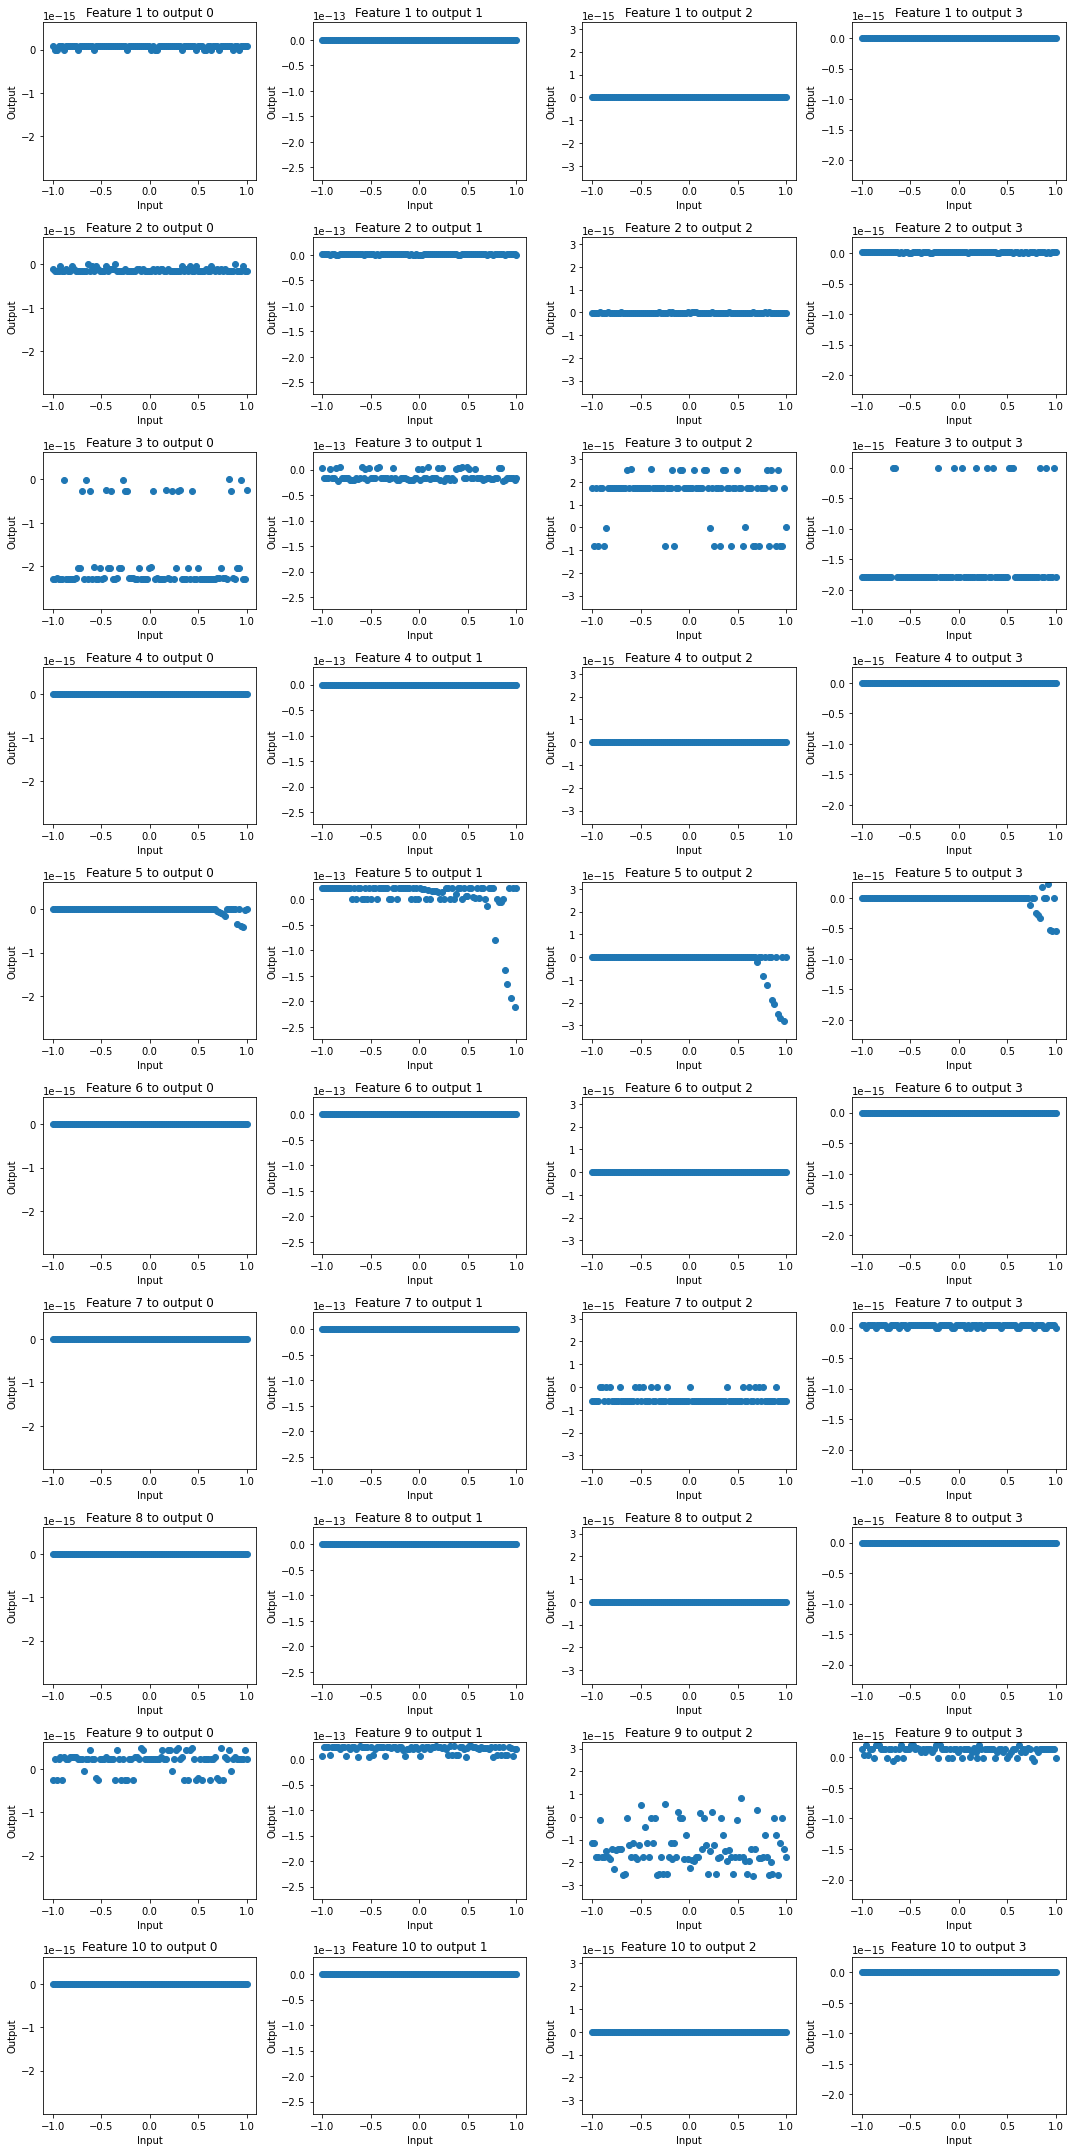

In [57]:
# Generate input values for plotting
x_values = torch.linspace(-1, 1, 100).reshape(-1, 1)  # 100 points between -1 and 1

vis_lat_features = True
input_dim = config['in_features']
output_dim = config['latent_dim']
visualize_gam(x_values, input_dim, output_dim, config, vis_lat_features)


In [ ]:
# # define experiment
# config = dict(
#             epochs=1000,#2000, #100
#             batch_size=1024, #128
#             learning_rate=0.0035,
#             weight_decay=0.0001,
#             num_exp = 5000,
#             in_features = 10,
        
#     #phase1 - latent features:
#             first_ActivateLayer_phase1 = LipschitzMonotonicLayer,  #ExULayer, ReLULayer, MonotonicLayer, LipschitzMonotonicLayer      
#             first_hidden_dim_phase1=128,  #1024          
#             shallow_phase1=False,
#             hidden_ActivateLayer_phase1 = LipschitzMonotonicLayer,
#             hidden_dim_phase1= [128,128], #[64, 32],
#             hidden_dropout_phase1=0,
#             feature_dropout_phase1=0,
#             latent_dim=4,
#             featureNN_arch_phase1='monotonic_hidden_layer', #parallel_single_output, multi_output, single_to_multi_output, monotonic_hidden_layer
#         #Monotonic_consrtains
#             weight_norms_kind_phase1 = "one-inf", 
#             group_size_phase1 = 2, 
#             monotonic_constraint_phase1 = None,
    
#     #phase2 - final outputs:
#             first_ActivateLayer_phase2 = ReLULayer,        
#             first_hidden_dim_phase2 = 64,            
#             shallow_phase2 = False,
#             hidden_ActivateLayer_phase2 = ReLULayer,
#             hidden_dim_phase2 =[64, 32],
#             hidden_dropout_phase2=0.2,
#             feature_dropout_phase2=0.2,
#             output_dim=2,
#             featureNN_arch_phase2='multi_output', #parallel_single_output, multi_output, single_to_multi_output, monotonic_hidden_layer
#         #Monotonic_consrtains
#             weight_norms_kind_phase2 = "one-inf", 
#             group_size_phase2 = 2, 
#             monotonic_constraint_phase2 = None, 
    
#             seed=42,
#             dataset="Uniform_distribution",
#             model_architecture="multi_output_NAM"
#             )

In [12]:
def make_mono(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])

    train_loader = make_loader(X, y, batch_size=config['batch_size'])

    # Make the model
    if len(config['hirarchical_net']) == 2:
        print('Training Hierarchical NAM...')
        print(f'Phase1 activation layers: {config['hirarchical_net'][0]}\nPhase2 activation layers: {config['hirarchical_net'][1]}')
    else:
        print('Training NAM...')
        print(f'Activation layers: {config['hirarchical_net'][0]}')
#     model = HierarchNeuralAdditiveModel(
#                         num_inputs= config['in_features'],
#                   #phase1 - latent_features:
#                         num_units_phase1= config['first_hidden_dim_phase1'],
#                         hidden_units_phase1= config['hidden_dim_phase1'],
#                         hidden_dropout_phase1 = config['hidden_dropout_phase1'],
#                         feature_dropout_phase1 = config['feature_dropout_phase1'],
#                         shallow_phase1 = config['shallow_phase1'],     
#                         first_layer_phase1 = config['first_ActivateLayer_phase1'],
#                         hidden_layer_phase1 = config['hidden_ActivateLayer_phase1'],
#                         latent_var_dim = config['latent_dim'],
#                         featureNN_architecture_phase1 = config['featureNN_arch_phase1'], 
#                   #phase2 - final outputs:
#                         num_units_phase2 = config['first_hidden_dim_phase2'],
#                         hidden_units_phase2 = config['hidden_dim_phase2'],
#                         hidden_dropout_phase2 = config['hidden_dropout_phase2'],
#                         feature_dropout_phase2 = config['feature_dropout_phase2'],
#                         shallow_phase2 = config['shallow_phase2'],
#                         first_layer_phase2 = config['first_ActivateLayer_phase2'],
#                         hidden_layer_phase2 = config['hidden_ActivateLayer_phase2'],          
#                         output_dim = config['output_dim'],
#                         featureNN_architecture_phase2 = config['featureNN_arch_phase2'],
#                         ).to(device)
                            
    model = NeuralAdditiveModel(num_inputs= config['in_features'],
                     num_units= config['first_hidden_dim_phase1'],
                     hidden_units= config['hidden_dim_phase1'],
                     hidden_dropout = config['hidden_dropout_phase1'],
                     feature_dropout = config['feature_dropout_phase1'],
                     shallow = config['shallow_phase1'],     
                     first_layer = config['first_ActivateLayer_phase1'],
                     hidden_layer = config['hidden_ActivateLayer_phase1'],
                     num_classes = config['latent_dim'],
                     architecture_type = config['featureNN_arch_phase1'],
                     weight_norms_kind = config['weight_norms_kind_phase1'],
                     group_size = config['group_size_phase1'], 
                     monotonic_constraint = config['monotonic_constraint_phase1'],        
                     ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer